In [60]:
import pandas as pd
import json
import numpy as np
import sys
from dtw import dtw
import os
import random
from sklearn.metrics import *
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from cydtw import dtw, dtw_path





In [61]:
#algoritmo principale
def DTWDistance(signalA, signalB, channel):
    n,m = len(signalA), len(signalB)
    DTW = np.zeros(shape=(n, m))
    for i in range(0,n):
        DTW[i,0] = np.finfo(dtype=float).max
    for i in range(0,m):
        DTW[0,i] = np.finfo(dtype=float).max
    DTW[0,0] = 0
    
    for i in range(1,n):
        for j in range(1,m):
            const = abs(signalA[i][channel] - signalB[j][channel])
            DTW[i,j] = const + min(DTW[i-1, j], DTW[i, j-1], DTW[i-1, j-1])
    
    return DTW[n - 1, m - 1]

In [62]:
#Algoritmo di scaling
def new_scale_df(data_frame, gyro, accl, pres):
    
    def scale(value, max_, min_):
        return (value - min_) / (max_ - min_)
        
    copy = data_frame.copy() 
    
    for wIndex in range(len(copy)):
        for vIndex in range(len(copy[wIndex])):
            copy[wIndex][vIndex][0] = scale(copy[wIndex][vIndex][0], accl, -accl)
            copy[wIndex][vIndex][1] = scale(copy[wIndex][vIndex][1], accl, -accl)
            copy[wIndex][vIndex][2] = scale(copy[wIndex][vIndex][2], accl, -accl)
            copy[wIndex][vIndex][3] = scale(copy[wIndex][vIndex][3], pres, 0)
            copy[wIndex][vIndex][4] = scale(copy[wIndex][vIndex][4], gyro, -gyro)
            copy[wIndex][vIndex][5] = scale(copy[wIndex][vIndex][5], gyro, -gyro)
            copy[wIndex][vIndex][6] = scale(copy[wIndex][vIndex][6], gyro, -gyro)
    
    return copy

In [63]:
def new_shift_df(data_frame, gyro, accl, pres):
    
    def shift(value, shifter):
        return value + shifter
    
    copy = data_frame.copy()
    
    for wIndex in range(len(copy)):
        for vIndex in range(len(copy[wIndex])):
            copy[wIndex][vIndex][0] = shift(copy[wIndex][vIndex][0], accl)
            copy[wIndex][vIndex][1] = shift(copy[wIndex][vIndex][1], accl)
            copy[wIndex][vIndex][2] = shift(copy[wIndex][vIndex][2], accl)
            copy[wIndex][vIndex][4] = shift(copy[wIndex][vIndex][4], gyro)
            copy[wIndex][vIndex][5] = shift(copy[wIndex][vIndex][5], gyro)
            copy[wIndex][vIndex][6] = shift(copy[wIndex][vIndex][6], gyro)
    
    return copy

In [64]:
with open('../dati/scrittura_di_computer/scaled/Dario_scaled.json', 'r') as f:
    data_giovanni = json.load(f)
with open('../dati/scrittura_di_computer/scaled/Antonio_scaled.json', 'r') as f:
    data_dario = json.load(f)

In [65]:
file_recog = ['Giulio_scaled.json']
file_path = '../dati/scrittura_di_computer/scaled/'
labelled_data_d, labelled_data_g = [], []

for file in os.listdir(file_path):
    if os.path.splitext(file)[1] != '.json': continue
    if file in file_recog: continue
    with open(os.path.join(file_path, file), 'r') as f:
        data_g = json.load(f)
    for i in range(len(data_g)):
        labelled_data_g.append((data_g[i], 0))
        
for path in file_recog:       
    with open(os.path.join(file_path, path), 'r') as f:
        data_r = json.load(f)
    for i in range(len(data_r)):
        labelled_data_d.append((data_r[i], 1))
    
def xy_data(labelled_data):
    x_data, y_labels = [], []
    for i in labelled_data:
        x_data.append(i[0])
        y_labels.append(i[1])
        
    return np.array(x_data), np.array(y_labels)

labelled_data_dg = labelled_data_d + labelled_data_g  
random.shuffle(labelled_data_dg)

data_dg, label_dg = xy_data(labelled_data_dg)


In [66]:

with open(os.path.join(file_path, file_recog[0]), 'r') as f:
    data = json.load(f)

check_word = data[10]
#l2_norm = lambda x, y: abs(x[i] - y[i])

similarity_arr = []
cost_matrix_arr = []
acc_cost_matrix_arr = []
for word in data_dg:
    similarity = 1 / (1 + dtw(np.array(word), np.array(check_word)))
    similarity_arr.append(similarity)

In [67]:
similarity_arr

[0.29824227400868397,
 0.30690327914718163,
 0.3206656259378632,
 0.2860043487632085,
 0.2993741087745624,
 0.272252236085502,
 0.28494637358649894,
 0.3071398006072933,
 0.3056277760101117,
 0.31296773891074525,
 0.2689961304060039,
 0.33535851221490126,
 0.28902138379237835,
 0.27580056962241295,
 0.38191919645667344,
 0.27615921531047577,
 0.2696660060035012,
 0.2869832356059362,
 0.32318735151228317,
 0.27259709796726167,
 0.2728649647962693,
 0.26797522719077577,
 0.2912688230600607,
 0.22702978345968955,
 0.2823410113335995,
 0.40236344001287183,
 0.49548707818002546,
 0.28355244881592573,
 0.31187210402190213,
 0.2910123921505757,
 0.26596234419126885,
 0.31410618283622793,
 0.29195889674942593,
 0.28819306417061985,
 0.2807868146122286,
 0.3116008835009541,
 0.3450750441195714,
 0.30116220445580316,
 0.31353328533880925,
 0.27217924342038696,
 0.2590188206479735,
 0.2860945717069381,
 0.29526404560013675,
 0.27416993513990695,
 0.29522343239022464,
 0.30189184991389945,
 0.2902

0.952759840098401

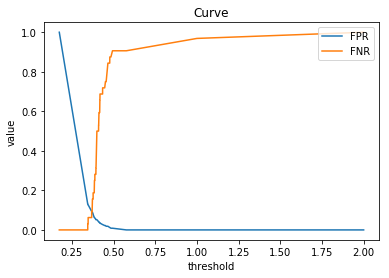

In [68]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import *


fpr, tpr , th= roc_curve(label_dg, similarity_arr)
fnr = 1 - tpr


plt.plot(th, fpr)
plt.plot(th, fnr)
plt.title('Curve')
plt.ylabel('value')
plt.xlabel('threshold')
plt.legend(['FPR', 'FNR'], loc='upper right')
plt.savefig('FPR_FNR_curve.svg')

roc_auc_score(label_dg, similarity_arr)


# escludiamo la pressione per ora perché è costante nel tempo e tende a diminuire le distanze fra due utenti

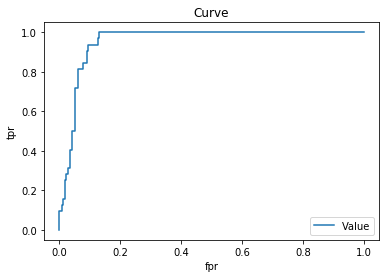

In [69]:
fpr, tpr , th= roc_curve(label_dg, similarity_arr)

plt.plot( fpr, tpr)
plt.title('Curve')
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.legend(['Value'], loc='lower right')
plt.savefig('ROC_CURVE.svg')

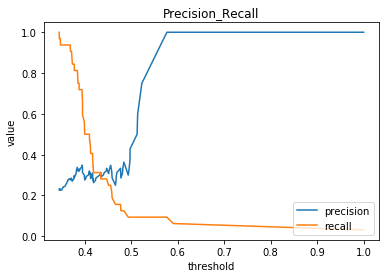

In [70]:
precision, recall, th = precision_recall_curve(label_dg, similarity_arr)
arr = np.delete(precision, [ precision.shape[0]-1])
arr_rec = np.delete(recall, [precision.shape[0]-1])


plt.plot(th,arr)
plt.plot(th,arr_rec)
plt.title('Precision_Recall')
plt.ylabel('value')
plt.xlabel('threshold')
plt.legend(['precision', 'recall'], loc='lower right')
plt.savefig('precision_recall_curve.svg')

#roc_auc_score(label_dg, media)

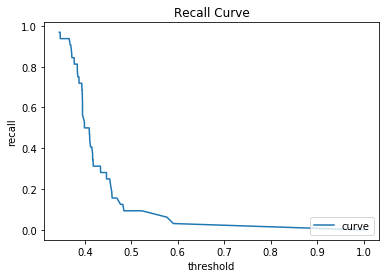

In [71]:
arr = np.delete(recall, 0)
plt.plot(th,arr)
plt.title('Recall Curve')
plt.ylabel('recall')
plt.xlabel('threshold')
plt.legend(['curve'], loc='lower right')
plt.savefig('recall_curve.svg')

In [72]:
matrix = np.zeros(shape=(len(scaled_dario),len(scaled_dario) + len(scaled_giovanni)))

for i in range(len(scaled_dario)):
    for j in range(len(scaled_dario)):
        for s in range(7):
            if s == 3: continue
            l2_norm = lambda x, y: abs(x[s] - y[s]) 
            d, _ , _ , _ = dtw(scaled_dario[i], scaled_dario[j], dist=l2_norm)
            matrix[i, j] += d
    for j in range(len(scaled_giovanni)):
        for s in range(7):
            if s == 3: continue
            l2_norm = lambda x, y: abs(x[s] - y[s])
            d, _ , _ , _ = dtw(scaled_dario[i], scaled_giovanni[j], dist=l2_norm)
            matrix[i, j + len(scaled_dario)] += d
    print(i)
            
matrix    

NameError: name 'scaled_dario' is not defined

In [ ]:
shifted_dario = new_scale_df(data_dario, 250, 2, 1024)
shifted_giovanni = new_scale_df(data_giovanni, 250, 2, 1024)

In [ ]:
matrix = np.zeros(shape=(len(shifted_dario),len(shifted_dario) + len(shifted_giovanni)))

for i in range(len(shifted_dario)):
    for j in range(len(shifted_dario)):
        l2_norm = lambda x, y: abs((sum(x) - x[3]) - (sum(y) - y[3])) 
        d, _ , _ , _ = dtw(shifted_dario[i], shifted_dario[j], dist=l2_norm)
        matrix[i, j] = d
    for j in range(len(shifted_giovanni)):
        l2_norm = lambda x, y: abs((sum(x) - x[3]) - (sum(y) - y[3]))
        d, _ , _ , _ = dtw(shifted_dario[i], shifted_giovanni[j], dist=l2_norm)
        matrix[i, j + len(shifted_dario)] = d
    print(i)
            
matrix

In [ ]:
matrix = np.zeros(shape=(len(scaled_dario),len(scaled_dario) + len(scaled_giovanni)))
matrix.fill(sys.maxsize)

for i in range(len(scaled_dario)):
    for j in range(len(scaled_dario)):
        for s in range(7):
            l2_norm = lambda x, y: abs(x[s] - y[s]) 
            d, _ , _ , _ = dtw(scaled_dario[i], scaled_dario[j], dist=l2_norm)
            matrix[i, j] = min(matrix[i, j], d)
    for j in range(len(scaled_giovanni)):
        for s in range(7):
            l2_norm = lambda x, y: abs(x[s] - y[s])
            d, _ , _ , _ = dtw(scaled_dario[i], scaled_giovanni[j], dist=l2_norm)
            matrix[i, j + len(scaled_dario)] = min(matrix[i, j + len(scaled_dario)], d)
    print(i)
            
matrix    

In [ ]:
d = pd.DataFrame(matrix)
for i in range(len(matrix)):
    print(i,':',(matrix[i]).argmax(), max(matrix[i]))

In [ ]:
d

In [ ]:
min_values, max_values = [], []
for i in range(len(matrix)):
    minv, maxv = (sys.maxsize, -1), (-sys.maxsize, -1)
    for j in range(len(matrix[i])):
        if i == j: 
            continue
        minv = (matrix[i][j], j) if minv[0] > matrix[i][j] else minv
        maxv = (matrix[i][j], j) if maxv[0] < matrix[i][j] else maxv
    min_values.append(minv)
    max_values.append(maxv)
    
for i in range(len(min_values)):
    print("index ", i, " min value: ", min_values[i])
        